# Cheat sheet - Moving Average Cross Over strategy
François Goujon

Content : Moving average strategy implementation with backtesting on real data.

Strategy : <br>
When the short term moving average crosses above the long term moving average, this indicates a buy signal. <br>
Contrary, when the short term moving average crosses below the long term moving average, it may be a good moment to sell.

2 versions : Simple Moving Average (SMA) and Exponentially Weigthed Moving Average (EMA)

### Table of Contents

* [Implementation](#imp)
    * [Functions](#maco_func)
    * [Results](#maco_res)
    
* [Back-testing](#bt)
    * [Functions](#bs_func)
    * [Results](#bs_res)
    
* [Full Analysis](#fa)
    * [Functions](#bs_func)
    * [Results](#bs_res)

## Implementation <a class="anchor" id="imp"></a>
### Imports

In [1]:
from datetime import date
import seaborn
import matplotlib.pyplot as plt
import yfinance as yf

## Functions <a class="anchor" id="maco_func"></a>

In [2]:
def get_data(ticker):
    """
    Retrieve data from yfinance
    Input: ticker (String)
    Output: price dataframe (pd.DataFrame)
    """
    df = yf.Ticker(ticker).history(period="5y")
    df.index = df.index.to_series().dt.date
    return df

def plot_price(data):
    """
    Plot price chart
    Input: data = price dataframe (pd.DataFrame)
    """
    data["Close"].plot(figsize=(12,6))
    plt.grid()
    plt.ylabel("Price")
    plt.show()
    
def add_sma(data, days):
    """
    Add Simple Moving Average column to the data
    Input: data = price dataframe (pd.DataFrame), days = SMA time parameter (int)
    """
    col_name = "SMA_" + str(days)
    data[col_name] = data["Close"].rolling(window = days, min_periods = 1).mean()
    
def add_ema(data, days):
    """
    Add EMA column to the data
    Input: data = price dataframe (pd.DataFrame), days = EMA time parameter (int)
    """
    col_name = "EMA_" + str(days) 
    data[col_name] = data["Close"].ewm(span = days, adjust = False).mean()
    
def add_signal(data, ma_short, ma_long, ma = "SMA"):
    """
    Add signal column to data : Short Timeframe (ST) MA over Long Timeframe (LT) MA -> Buy else Sell
    Input: data = price dataframe with MA columns added (pd.DataFrame),
    ma_short = days for ST MA (int), ma_long = days for LT MA (int), ma = type of MA: "SMA"/"EMA"
    """
    ma_short_label = ma + "_" + str(ma_short)
    ma_long_label = ma + "_" + str(ma_long)
    label_stlt = "STOverLT_" + ma
    label_pos = "Position_" + ma
    data[label_stlt] = np.where(data[ma_short_label] > data[ma_long_label], 1.0, 0.0)
    data[label_pos] = data[label_stlt].diff()
    
def plot_ma(data, ma = "SMA", show = True):
    """
    Plot price chart with MA 
    Input: data = price dataframe (pd.DataFrame), ma = type of MA: "SMA"/"EMA"
    show: show plot (boolean) 
    """
    cols = ["Close"]
    for c in data.columns:
        if ma+"_" in c:
            cols.append(c)
    data[cols].plot(figsize=(12,6))
    plt.grid()
    plt.ylabel("Price")
    if show:
        plt.show()
        
def plot_signal(data, ma = "SMA"):
    """
    Plot price chart with MA and buy/sell signals
    Input: data = price dataframe with signal column added (pd.DataFrame), ma = type of MA: "SMA"/"EMA"
    """
    label_pos = "Position_" + ma
    plot_ma(data, ma, False)
    # Buy signal
    buy_idx = data[data[label_pos] == 1].index
    buy_pr = data["Close"][data[label_pos] == 1]
    plt.plot(buy_idx, buy_pr, "^", markersize = 15, color = 'g', alpha = 0.7, label = 'buy')
    # Sell signal
    sell_idx = data[data[label_pos] == -1].index
    sell_pr = data["Close"][data[label_pos] == -1]
    plt.plot(sell_idx, sell_pr, "^", markersize = 15, color = 'r', alpha = 0.7, label = 'sell')
    plt.legend()
    plt.title(ma + " crossover")
    plt.show()
    
def signal_table(data, ma = "SMA"):
    """
    Return buy/sell signals table
    Input: data = price dataframe with signal column added (pd.DataFrame), ma = type of MA: "SMA"/"EMA"
    """
    label_pos = "Position_" + ma
    df_pos = data[["Close", label_pos]][(data[label_pos] == 1) | (data[label_pos] == -1)]
    df_pos[label_pos] = df_pos[label_pos].apply(lambda x: 'Buy' if x == 1 else 'Sell')
    return df_pos
    
def ma_analysis(ticker, short, long, ma = 'both'):
    """
    Plot price chart with MA and buy/sell signals
    Input: ticker (String), short = days for ST MA (int),
    long = days for LT MA (int), ma = type of MA: "SMA"/"EMA"/"both"
    Output: d = price dataframe with MA and signal columns added
    """
    b_sma, b_ema = False, False
    if ma == "both":
        b_sma, b_ema = True, True
    elif ma == "SMA":
        b_sma = True
    elif ma == "EMA":
        b_ema = True
        
    d = get_data(ticker)
    # SMA
    if b_sma:
        add_sma(d, short)
        add_sma(d, long)
        add_signal(d, short, long, "SMA")
    # EMA
    if b_ema:
        add_ema(d, short)
        add_ema(d, long)
        add_signal(d, short, long, "EMA")
    # Plots
    if b_sma:
        plot_signal(d, "SMA")
    if b_ema:
        plot_signal(d, "EMA")
    return d
    

## Results <a class="anchor" id="maco_res"></a>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

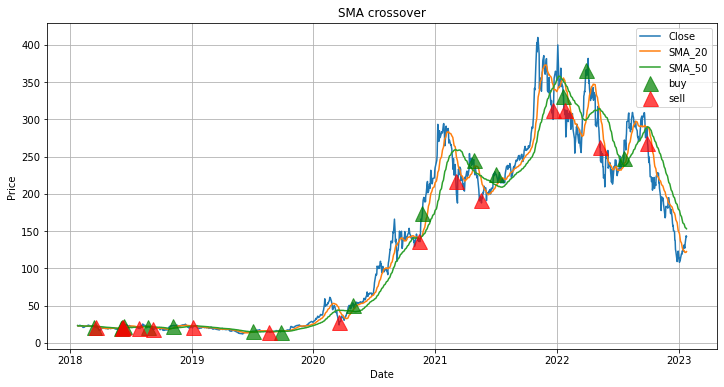

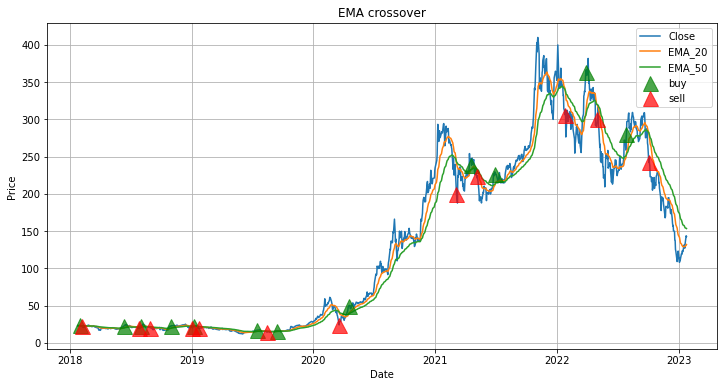

In [3]:
# SMA and EMA crossover
d = ma_analysis("TSLA", 20, 50)

In [4]:
signal_table(d, "EMA")

,Close,Position_EMA
Date,,
2018-01-31,23.620667,Buy
2018-02-05,22.208668,Sell
2018-06-11,22.139999,Buy
2018-07-26,20.443333,Sell
2018-08-03,23.211332,Buy
2018-08-30,20.209999,Sell
2018-10-31,22.488001,Buy
2019-01-03,20.024000,Sell
2019-01-09,22.568666,Buy


In [7]:
# Access a row from data
d.loc[date(2022, 10, 3)] 

Open            2.545000e+02
High            2.551600e+02
Low             2.410100e+02
Close           2.424000e+02
Volume          9.836350e+07
Dividends       0.000000e+00
Stock Splits    0.000000e+00
SMA_20          2.879230e+02
SMA_50          2.893600e+02
STOverLT_SMA    0.000000e+00
Position_SMA    0.000000e+00
EMA_20          2.819811e+02
EMA_50          2.820625e+02
STOverLT_EMA    0.000000e+00
Position_EMA   -1.000000e+00
Name: 2022-10-03, dtype: float64

## Back-testing <a class="anchor" id="bt"></a>
### Functions <a class="anchor" id="bt_func"></a>

In [15]:
def add_daily_returns(data):
    """
    Add daily return in % to data
    Input: data = price dataframe (pd.DataFrame)
    """
    data["D_returns"] = data["Close"].pct_change(1)

def plot_daily_returns(data):
    """
    Plot histogram of daily returns of asset
    Input: data = price dataframe with daily returns column added (pd.DataFrame)
    """
    data["D_returns"].hist(bins=30, figsize=(12,6))
    plt.ylabel("Frequency")
    plt.xlabel("Daily Returns")
    plt.show()
    
def compute_ma_returns(data, ma = "SMA"):
    """
    Compute returns of MA crossover strategy (Buy when ST MA > LT MA, Sell otherwise)
    Input: data = price dataframe with signal column added (pd.DataFrame), ma = type of MA: "SMA"/"EMA"
    Output: df_pos = dataframe with buy/sell dates and % change since last (pd.DataFrame)
    """
    # Keep dates where we change position
    label_pos = "Position_" + ma
    df_pos = data[["Close", label_pos]][(data[label_pos] == 1) | (data[label_pos] == -1)]
    # Compute the return for each sell and buy 
    label_ret = ma + "_returns"
    df_pos[label_ret] = df_pos["Close"].pct_change(1) # Variation of price between position change
    df_pos[label_ret][df_pos[label_pos] == 1] = - df_pos[label_ret][df_pos[label_pos] == 1] # Replacing by opposite value for shorts (When we buy after a sell)
    # Compute cumulative returns
    label_real_ret = ma + "_real_returns"
    label_cumul_L = ma + "_cumul_return_long_only"
    label_cumul_S = ma + "_cumul_return_short_only"
    label_cumul_LS = ma + "_cumul_return_long_short"
    df_pos[label_real_ret] = df_pos[label_ret] + 1 # Each time we long 1 or short 1 (ie sell or buy 2 at change of position)
    df_pos[label_cumul_LS] = df_pos[label_real_ret].cumprod() # Long-Short returns
    temp = df_pos[label_real_ret].copy() # Temp save while we do calculation for short only and long only
    df_pos[label_real_ret][df_pos[label_pos] == 1] = 1 # Long : Keep only returns when selling (so returns when buying at 1)
    df_pos[label_cumul_L] = df_pos[label_real_ret].cumprod() # Long returns
    df_pos[label_real_ret] = temp # Reset of returns
    df_pos[label_real_ret][df_pos[label_pos] == -1] = 1 # Short : Keep only returns when buying (so returns when selling at 1)
    df_pos[label_cumul_S] = df_pos[label_real_ret].cumprod() # Short returns
    df_pos[label_real_ret] = temp # Reset of returns
    
    return df_pos

def plot_ma_returns(ma_returns, ma = "SMA", ls="longshort"):
    """
    Plot MA crossover strategy histogram of returns
    Input: data = price dataframe with MA returns column added (pd.DataFrame)
    ma = type of MA: "SMA"/"EMA"
    ls = long/short : "long" or "short" or "longshort
    """
    label_ret = ma + "_returns"
    label_pos = "Position_" + ma
    if ls == "long":
        ma_returns[label_ret][ma_returns[label_pos] == -1].hist(bins=30, figsize=(12,6))
    elif ls == "short":
        ma_returns[label_ret][ma_returns[label_pos] == 1].hist(bins=30, figsize=(12,6))
    elif ls == "longshort":
        ma_returns[label_ret].hist(bins=30, figsize=(12,6))
    else:
        raise("Wrong ls")
    plt.ylabel("Frequency")
    plt.xlabel(ma + " Strategy Returns")
    plt.title("Histogram of returns")
    plt.show()

def plot_cumul_returns(ma_returns, ma = "SMA"):
    """
    Plot cumulative return of MA strategy with long-only, short-only and long-short
    Input: ma_returns = dataframe with returns of MA crossover strategy (pd.DataFrame),
    ma = type of MA: "SMA"/"EMA"
    """
    cols = []
    for c in ma_returns.columns:
        if ma+"_cumul_return" in c:
            cols.append(c)
    ma_returns[cols].plot(figsize=(12,6))
    plt.ylabel("Cumulative return")
    plt.title(ma + " Strategy Cumulative Returns")
    plt.show()
    
def ma_bt_analysis(ticker, short, long, ma = "EMA"):
    """
    Plot price chart with MA and buy/sell signals and cumulative returns chart
    Input: ticker (String), short = days for ST MA (int),
    long = days for LT MA (int), ma = type of MA: "SMA"/"EMA"/"both"
    """
    d = ma_analysis(ticker, short, long, ma)
    b_sma, b_ema = False, False
    if ma == "both":
        b_sma, b_ema = True, True
    elif ma == "SMA":
        b_sma = True
    elif ma == "EMA":
        b_ema = True

    res = []
    if b_sma:
        sma_ret = compute_ma_returns(d, "SMA")
        res.append(sma_ret)
        plot_cumul_returns(sma_ret, "SMA")
    if b_ema:
        ema_ret = compute_ma_returns(d, "EMA")
        res.append(ema_ret)
        plot_cumul_returns(ema_ret, "EMA")
    return d, res
        
# TODO : NOT ONLY LONG : LONG/SHORT
# ROLLING SHARPE RATIO

## Results <a class="anchor" id="bt_res"></a>

In [9]:
add_daily_returns(d)

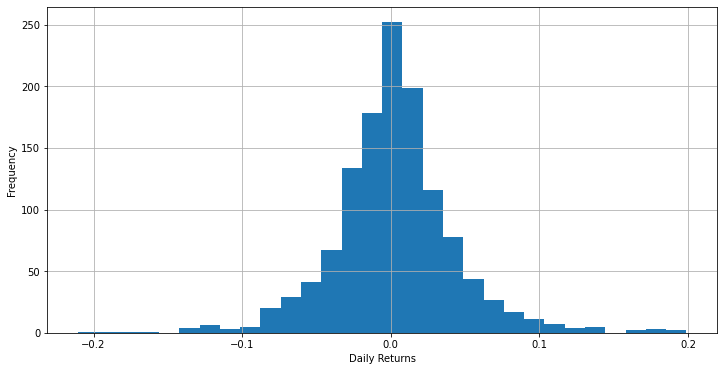

In [10]:
# Histogram of daily returns of asset
plot_daily_returns(d)

In [11]:
# Computation of ma strategy returns
ma_ret = compute_ma_returns(d, ma = "EMA")

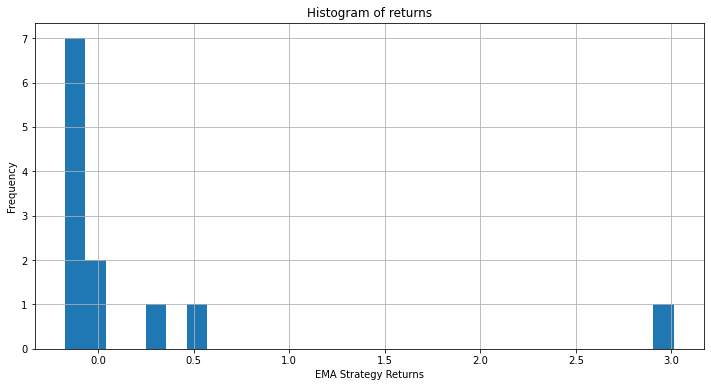

In [17]:
# Histogram of ma strategy returns with long only
plot_ma_returns(ma_ret, ma = "EMA", ls ="long")

# Full analysis <a class="anchor" id="fa"></a>

<IPython.core.display.Javascript object>

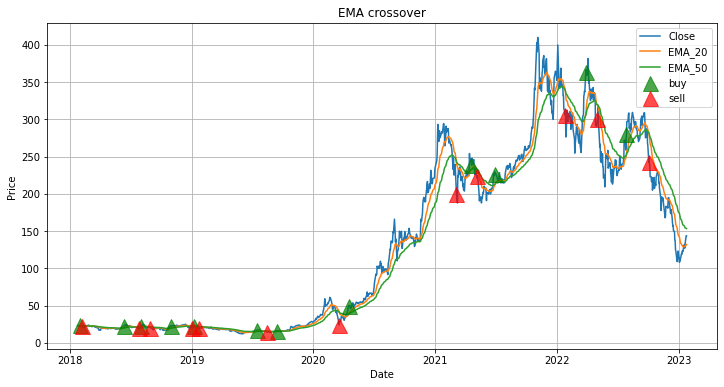

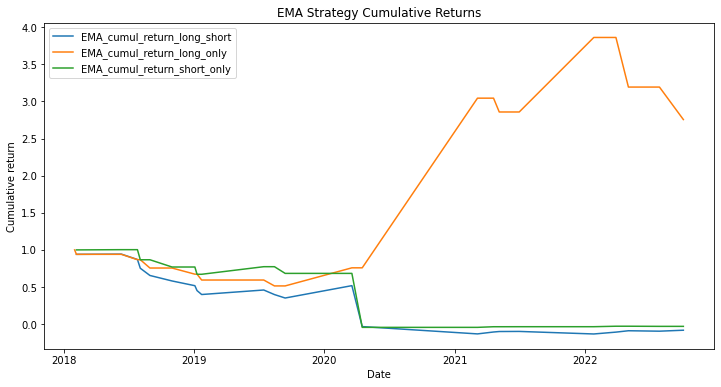

In [18]:
tsla_data , tsla_ema_ret = ma_bt_analysis("TSLA", 20, 50, "EMA")

<IPython.core.display.Javascript object>

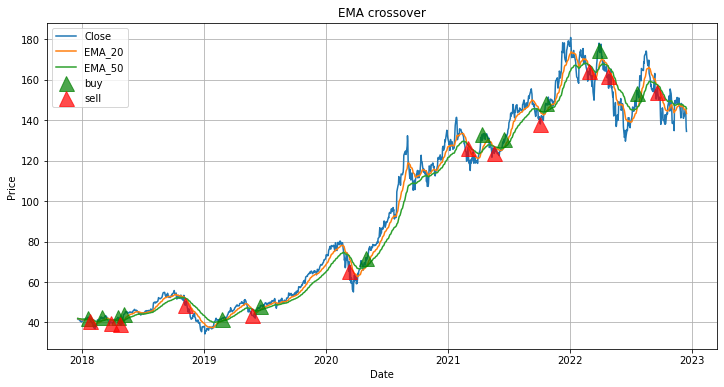

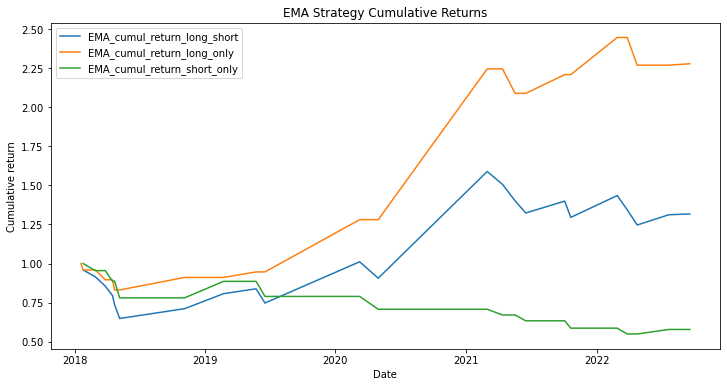

In [48]:
aapl_data, aapl_ema_ret = ma_bt_analysis("AAPL", 20, 50, "EMA")

<IPython.core.display.Javascript object>

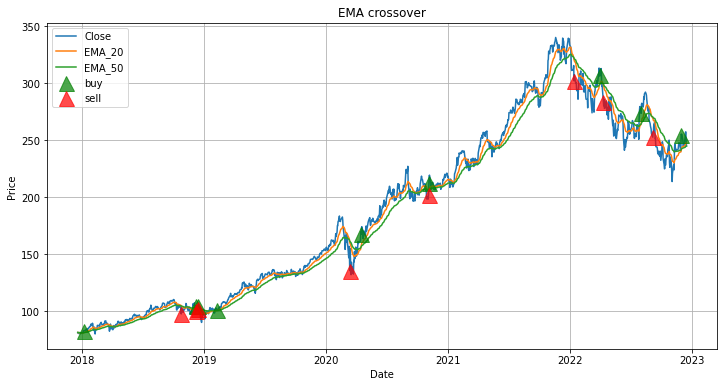

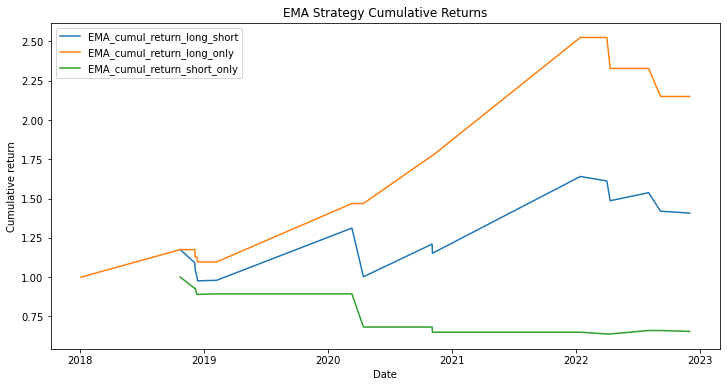

In [49]:
msft_data, msft_ema_ret = ma_bt_analysis("MSFT", 20, 50, "EMA")

<IPython.core.display.Javascript object>

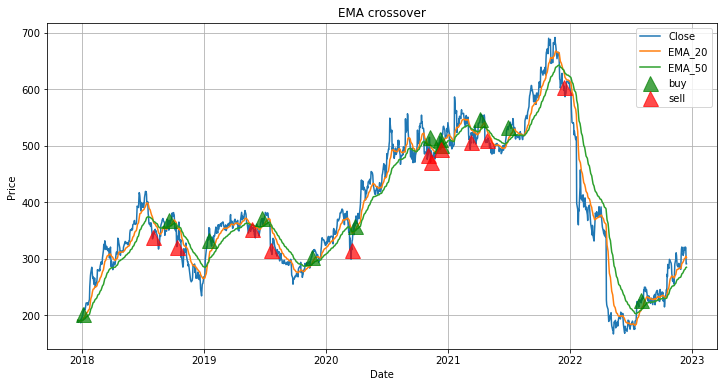

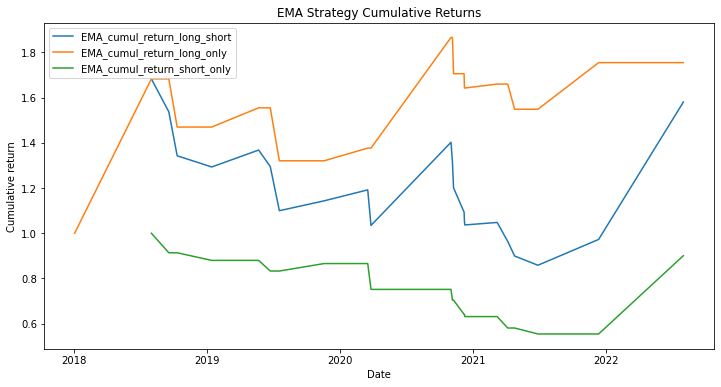

In [50]:
nflx_data, nflx_ema_ret = ma_bt_analysis("NFLX", 20, 50, "EMA")

<IPython.core.display.Javascript object>

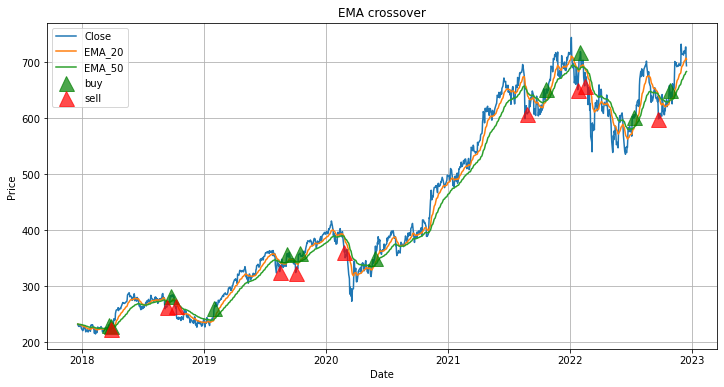

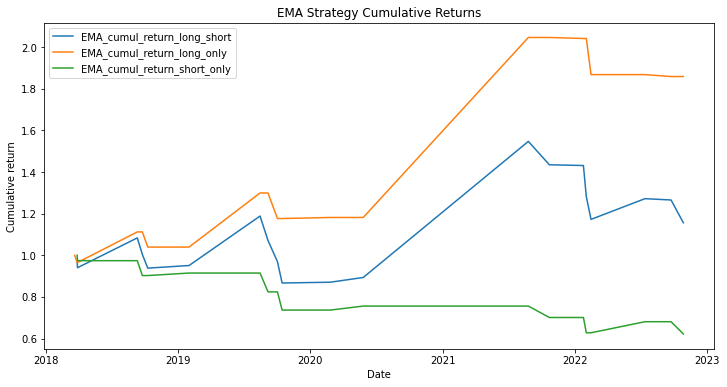

In [52]:
mcpa_data, mcpa_ema_ret = ma_bt_analysis("MC.PA", 20, 50, "EMA")

<IPython.core.display.Javascript object>

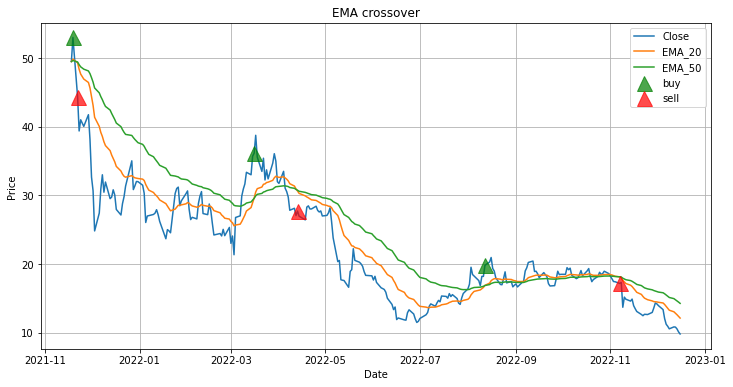

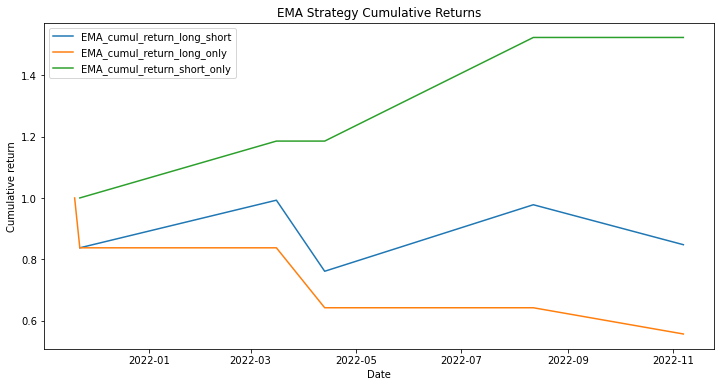

In [53]:
sg_data, sg_ema_ret = ma_bt_analysis("SG", 20, 50, "EMA")